# Hand Detection

Computer Vision project UniPD, 2022.

**Group 55**: Grotto Gionata, Mosco Simone, Pisacreta Giulia.

**Description:** The aim of this notebook is training a network for the specific task of Human Hand Detection, reporting in output the bounding box format for each occurrence of a hand in the input image. The network used for this purpose is the [YOLOv5](https://github.com/ultralytics/yolov5) model over a custom dataset, with fine-tuning. In the last cells it is possible to download the *.onnx* model in order to import it in C++ code.

Packages required

In [2]:
!pip install opencv-python==4.5.5.62
import os
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

#mat files
!pip install mat4py
from mat4py import loadmat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.4 MB 1.1 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.2.52
    Uninstalling opencv-python-4.5.2.52:
      Successfully uninstalled opencv-python-4.5.2.52
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dataset

Two different dataset have been tested for fine-tuning the YOLOv5 network:

* Hand Dataset: a collection of hand images taken from various different public image data set sources, available at the following link (https://www.robots.ox.ac.uk/~vgg/data/hands/)

* Our Custom Dataset: set of images collected by us and integrated with some other images from the EgoHands Dataset (http://vision.soic.indiana.edu/projects/egohands/) which do not compare in the Test Set provided by the professor.

We figured out that using the second dataset, the one we assembled, the performance and the accuracy on the Test Set are really greater so we will refer to this dataset for the current task. However all the code for the other dataset is available below in the hidden cells but may require some editing.

### Our Custom Dataset

Connect your Google Drive to the notebook and make sure that the file *custom_dataset.zip* is located in the main folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#create folder
!mkdir /content/dataset

#unzip into new folder folder
!unzip '/content/drive/MyDrive/custom_dataset.zip' -d '/content/data'

### Hand Dataset

The dataset (https://www.robots.ox.ac.uk/~vgg/data/hands/) wiil be placed in the *dataset* folder and it has the following structure:

dataset
- training_dataset
  * training_data
    - annotations
    - images
- test_dataset
  * test_data
    - annotations
    - images
- validation_dataset
  * validation_data
    - annotations
    - images


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#create folder
!mkdir /content/dataset

#unzip into new folder folder
!tar -xzvf '/content/drive/MyDrive/hand_dataset.tar.gz' -C '/content/dataset'

#### Import Dataset

Import the three Train, Test and Validation dataset

In [ ]:
#function to load a dataset from its directory
def load_dataset(path):
  data = []
  images_path = os.path.join(path, 'images')
  annotations_path = os.path.join(path, 'annotations')

  for img_name in os.listdir(images_path):
    ann_name = img_name[:-3] + 'mat'
    try:
      #get image
      img = cv2.imread(os.path.join(images_path, img_name))
      #convert to rgb
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      #TODO: resize image (?)

      #get annotations and convert it
      boxes = loadmat(os.path.join(annotations_path, ann_name))['boxes']
      if type(boxes) == list:
        annotations = [list(box.values())[:4] for box in boxes]
      elif type(boxes) == dict:
        annotations = list(boxes.values())[:4]
      data.append([img, annotations])
    except Exception as e:
      print(e)
  return np.array(data)


#path of the datasets
data_dir = Path('/content/dataset/hand_dataset')
train_dir = os.path.join(data_dir, 'training_dataset/training_data')
val_dir = os.path.join(data_dir, 'validation_dataset/validation_data')
test_dir = os.path.join(data_dir, 'test_dataset/test_data')

train_dataset = load_dataset(train_dir)
val_dataset = load_dataset(val_dir)
test_dataset = load_dataset(test_dir)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



Visualize a sample and its annotations

In [ ]:
print('Annotations: ')
print(train_dataset[0][1])

Annotations: 
[[[562.4451166213178, 268.77859712609444], [551.6529225943682, 309.3683562789235], [606.868608868878, 324.0493598631528], [617.6608028958276, 283.45960071032374]], [[538.583272350313, 392.4741413808229], [557.9461394143926, 429.74449661200873], [653.3186884340005, 380.19610951523447], [633.9558213699208, 342.92575428404865]], [[578.3526678747818, 496.00006413367896], [543.2747831056103, 540.9282512785073], [617.3139987918847, 598.7347028914106], [652.3918835610563, 553.8065157465822]], [[557.8067581401061, 693.8621660877592], [616.5265751932269, 713.7614898262192], [651.6638300951878, 610.0769020125991], [592.944013042067, 590.1775782741391]]]


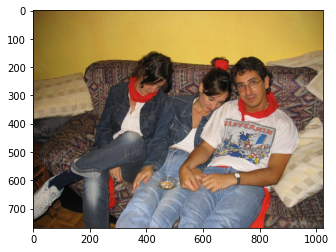

In [ ]:
plt.imshow(train_dataset[0][0])

In order to obtain bounding boxes with only vertical and horizontal lines, we transform the default ones into the following format:

    [x top left corner, y top left corner, width, height]

In [ ]:
def convert_bbox(values):
  #values is a list of points as [[y1, x1], [y2, x2], [y3, x3], [y4, x4]]
  
  x_min = int(min([point[1] for point in values]))
  y_min = int(min([point[0] for point in values]))
  width = int(max([point[1] for point in values]) - x_min)
  height = int(max([point[0] for point in values]) - y_min)

  return [x_min, y_min, width, height]

In [ ]:
def convert_dataset(dataset):
  new_dataset = []
  for sample in dataset:
    #case with only a hand in the image
    if len(sample[1][0]) == 2:
      boxes = convert_bbox(sample[1])
    else:
      boxes = [convert_bbox(box) for box in sample[1]]
    new_dataset.append([sample[0], boxes])

  return np.array(new_dataset)

In [ ]:
train_set = convert_dataset(train_dataset)
val_set = convert_dataset(val_dataset)
test_set = convert_dataset(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


Display a sample image with the custom bounding boxes

In [ ]:
def draw_boxes(img, boxes):
  image = img.copy()
  color = (0, 255, 0)
  #case where only a hand is present in the image
  if isinstance(boxes[0], int):
    point1 = (boxes[0], boxes[1])
    point2 = (boxes[0]+boxes[2], boxes[1]+boxes[3])
    image = cv2.rectangle(image, point1, point2, color, 2)
  else:
    for box in boxes:
      point1 = (box[0], box[1])
      point2 = (box[0]+box[2], box[1]+box[3])
      image = cv2.rectangle(image, point1, point2, color, 2)

  plt.imshow(image)

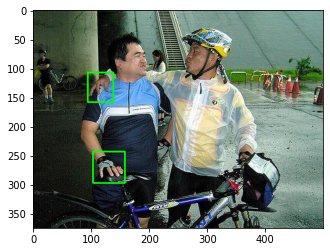

In [ ]:
sample_num = 5
draw_boxes(train_set[sample_num][0], train_set[sample_num][1])

**Dataset Structure**

    dataset[0] = image and annotations
    dataset[0][0] = image
    dataset[0][1] = annotations

#### Preprocessing

All the labels must be in the following format:

    class x_center y_center width height

where the attribute class is the same for all the image and equal to zero, while the other property must be normalized with values between 0 and 1.

In [ ]:
def set_labels(box, old_shape):
  x_center = (box[0]*2 + box[2])/(2*old_shape[1])
  y_center = (box[1]*2 + box[3])/(2*old_shape[0])
  width = box[2]/old_shape[1]
  height = box[3]/old_shape[0]

  return [x_center, y_center, width, height]

In [ ]:
def prepare_dataset(dataset):
  data = []
  for sample in dataset:
    shape = sample[0].shape
    #modify the labels
    if isinstance(sample[1][0], int):
      labels = set_labels(sample[1], shape)
    else:
      labels = [set_labels(box, shape) for box in sample[1]]
    data.append([sample[0], labels])

  return np.array(data)

In [ ]:
train_data = prepare_dataset(train_set)
val_data = prepare_dataset(val_set)
test_data = prepare_dataset(test_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Visualize and print labels of a sample

ORIGINAL IMAGE
Labels:  [194, 117, 17, 17]


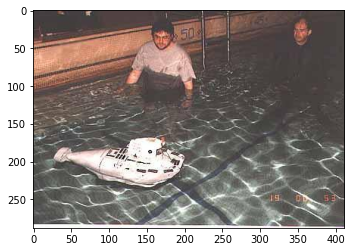

In [ ]:
print('ORIGINAL IMAGE')
print('Labels: ', train_set[1010][1])
plt.imshow(train_set[1010][0])

MODIFIED IMAGE
Labels:  [0.49150485436893204, 0.4357638888888889, 0.0412621359223301, 0.059027777777777776]


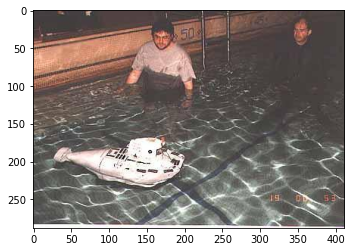

In [ ]:
print('MODIFIED IMAGE')
print('Labels: ', train_data[1010][1])
plt.imshow(train_data[1010][0])

Save the new dataset, containing resized image and normalized coordinates in specific folders

In [ ]:
#create folders for the final dataset
!mkdir data
!mkdir data/train_set
!mkdir data/train_set/images
!mkdir data/train_set/labels
!mkdir data/val_set
!mkdir data/val_set/images
!mkdir data/val_set/labels
!mkdir data/test_set
!mkdir data/test_set/images
!mkdir data/test_set/labels

In [ ]:
#function to save the modified dataset
def save_dataset(path, data):
  img_path = path + '/images/'
  label_path = path + '/labels/'

  #loop through the dataset
  for i, sample in enumerate(data):
    img_name = 'im' + str(i) + '.jpg'
    label_name = 'im' + str(i) + '.txt'
    #save image
    cv2.imwrite(img_path+img_name, sample[0])
    #print(sample[1])
    #create txt file for labels
    f = open(label_path+label_name, 'w')
    #save the annotations
    if isinstance(sample[1][0], float):
      f.write('0')
      for elem in sample[1]:
        f.write(' ' + str(elem))
    else:
      for label in sample[1]:
        #print(label)
        f.write('0')
        for elem in label:
          f.write(' ' + str(elem))
        f.write('\n') #TODO: adjust the new line created (?)

In [ ]:
save_dataset('/content/data/train_set', train_data)
save_dataset('/content/data/val_set', val_data)
save_dataset('/content/data/test_set', test_data)

In [ ]:
#delete the initial dataset directory to free space
!rm -r /content/dataset

### Training with **YOLOv5**

Import file *custom_data.yaml* from Drive and rename it as *data.yaml*

In [8]:
!cp -r /content/drive/MyDrive/custom_data.yaml /content/data.yaml

Install YOLOv5 and requirements (it might takes a while)

In [4]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 12779, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 12779 (delta 32), reused 45 (delta 25), pack-reused 12719
Receiving objects: 100% (12779/12779), 12.41 MiB | 25.77 MiB/s, done.
Resolving deltas: 100% (8787/8787), done.
/content/yolov5
     |████████████████████████████████| 596 kB 30.9 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 57.4 MB/s 
     |████████████████████████████████| 178 kB 71.2 MB/s 
     |████████████████████████████████| 145 kB 70.4 MB/s 
     |████████████████████████████████| 138 kB 68.0 MB/s 
     |████████████████████████████████| 67 kB 7.5 MB/s 
     |████████████████████████████████| 21.6 MB 1.4 MB/s 
     |████████████████████████████████| 4.3 MB 35.0 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
ERROR: pip's dependency resolver does not currently take into ac

Train the network including image size, batch size, number of epochs, dataset location, weights used, cache for images

In [9]:
!python /content/yolov5/train.py --img 640 --batch 16 --epochs 100 --data /content/data.yaml --weights yolov5n.pt --cache

train: weights=yolov5n.pt, cfg=, data=/content/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_

Detection on the test set (remember to modify the path to exp*N*)

In [ ]:
#!python /content/yolov5/detect.py --weights /content/yolov5/runs/train/exp3/weights/best.pt --img 512 --conf 0.1 --source /content/data/test_set/images

In [10]:
!python /content/yolov5/val.py --weights /content/yolov5/runs/train/exp3/weights/best.pt --data /content/data.yaml --img 512

val: data=/content/data.yaml, weights=['/content/yolov5/runs/train/exp3/weights/best.pt'], batch_size=32, imgsz=512, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
val: Scanning '/content/data/valid/labels.cache' images and labels... 10 found, 0 missing, 0 empty, 0 corrupt: 100% 10/10 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 1/1 [00:00<00:00,  2.00it/s]
                 all         10         30      0.951        0.9       0.97      0.658
Speed: 0.1ms pre-process, 4.1ms inference, 1.0ms NMS per image at shape (32, 3, 512, 512)
Results saved to runs

**Export model to onxx format** and download it (remember to modify the path to exp*N*)

In [12]:
!python /content/yolov5/export.py --weights /content/yolov5/runs/train/exp3/weights/best.pt --include onnx --simplify

export: data=data/coco128.yaml, weights=['/content/yolov5/runs/train/exp3/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, train=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.7.13 torch-1.12.0+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs

PyTorch: starting from /content/yolov5/runs/train/exp3/weights/best.pt with output shape (1, 25200, 6) (3.7 MB)
requirements: onnx not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per ['onnx']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with

In [13]:
#download the file
from google.colab import files
files.download('/content/yolov5/runs/train/exp3/weights/best.onnx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
#simple check of the onnx model
#it works only with opencv version >= 4.5.5
#model = cv2.dnn.readNet('/content/yolov5/runs/train/exp3/weights/best.onnx')